In [1]:
import sys
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf


In [74]:
# Plot settings is a custom module which sets the plot style
sys.path.append(os.path.abspath("../src/visualization"))
from plot_settings import set_plot_style

set_plot_style()


## 1. Read 

In [3]:
X_train, y_train, X_val, y_val, X_test = pd.read_pickle("../data/processed/data.pkl")
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape


((37800, 28, 28, 1),
 (37800, 10),
 (4200, 28, 28, 1),
 (4200, 10),
 (28000, 28, 28, 1))

#####  our model was included custom function(f1_m, precision_m, recall_m). when we want use "load_model" we need to mention that custom_object and import them to this file

In [4]:
sys.path.append(os.path.abspath("../src/models"))
from metrics import f1_m, precision_m, recall_m

model = tf.keras.models.load_model(
    "../models/best_model.h5",
    custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m},
)


## 2. Validation results

In [13]:
# we use argmax to get the index of the max value in each row
y_val_pred = np.argmax(model.predict(X_val), axis=1)
print("y_val_pred", y_val_pred)
y_val_true = np.argmax(y_val, axis=1)
print("y_val_true", y_val_true)


132/132 [==============================] - 0s 3ms/step
y_val_pred [8 1 9 ... 7 7 5]
y_val_true [8 1 9 ... 7 7 5]


#### 2.1 Plot Confusion Matrix

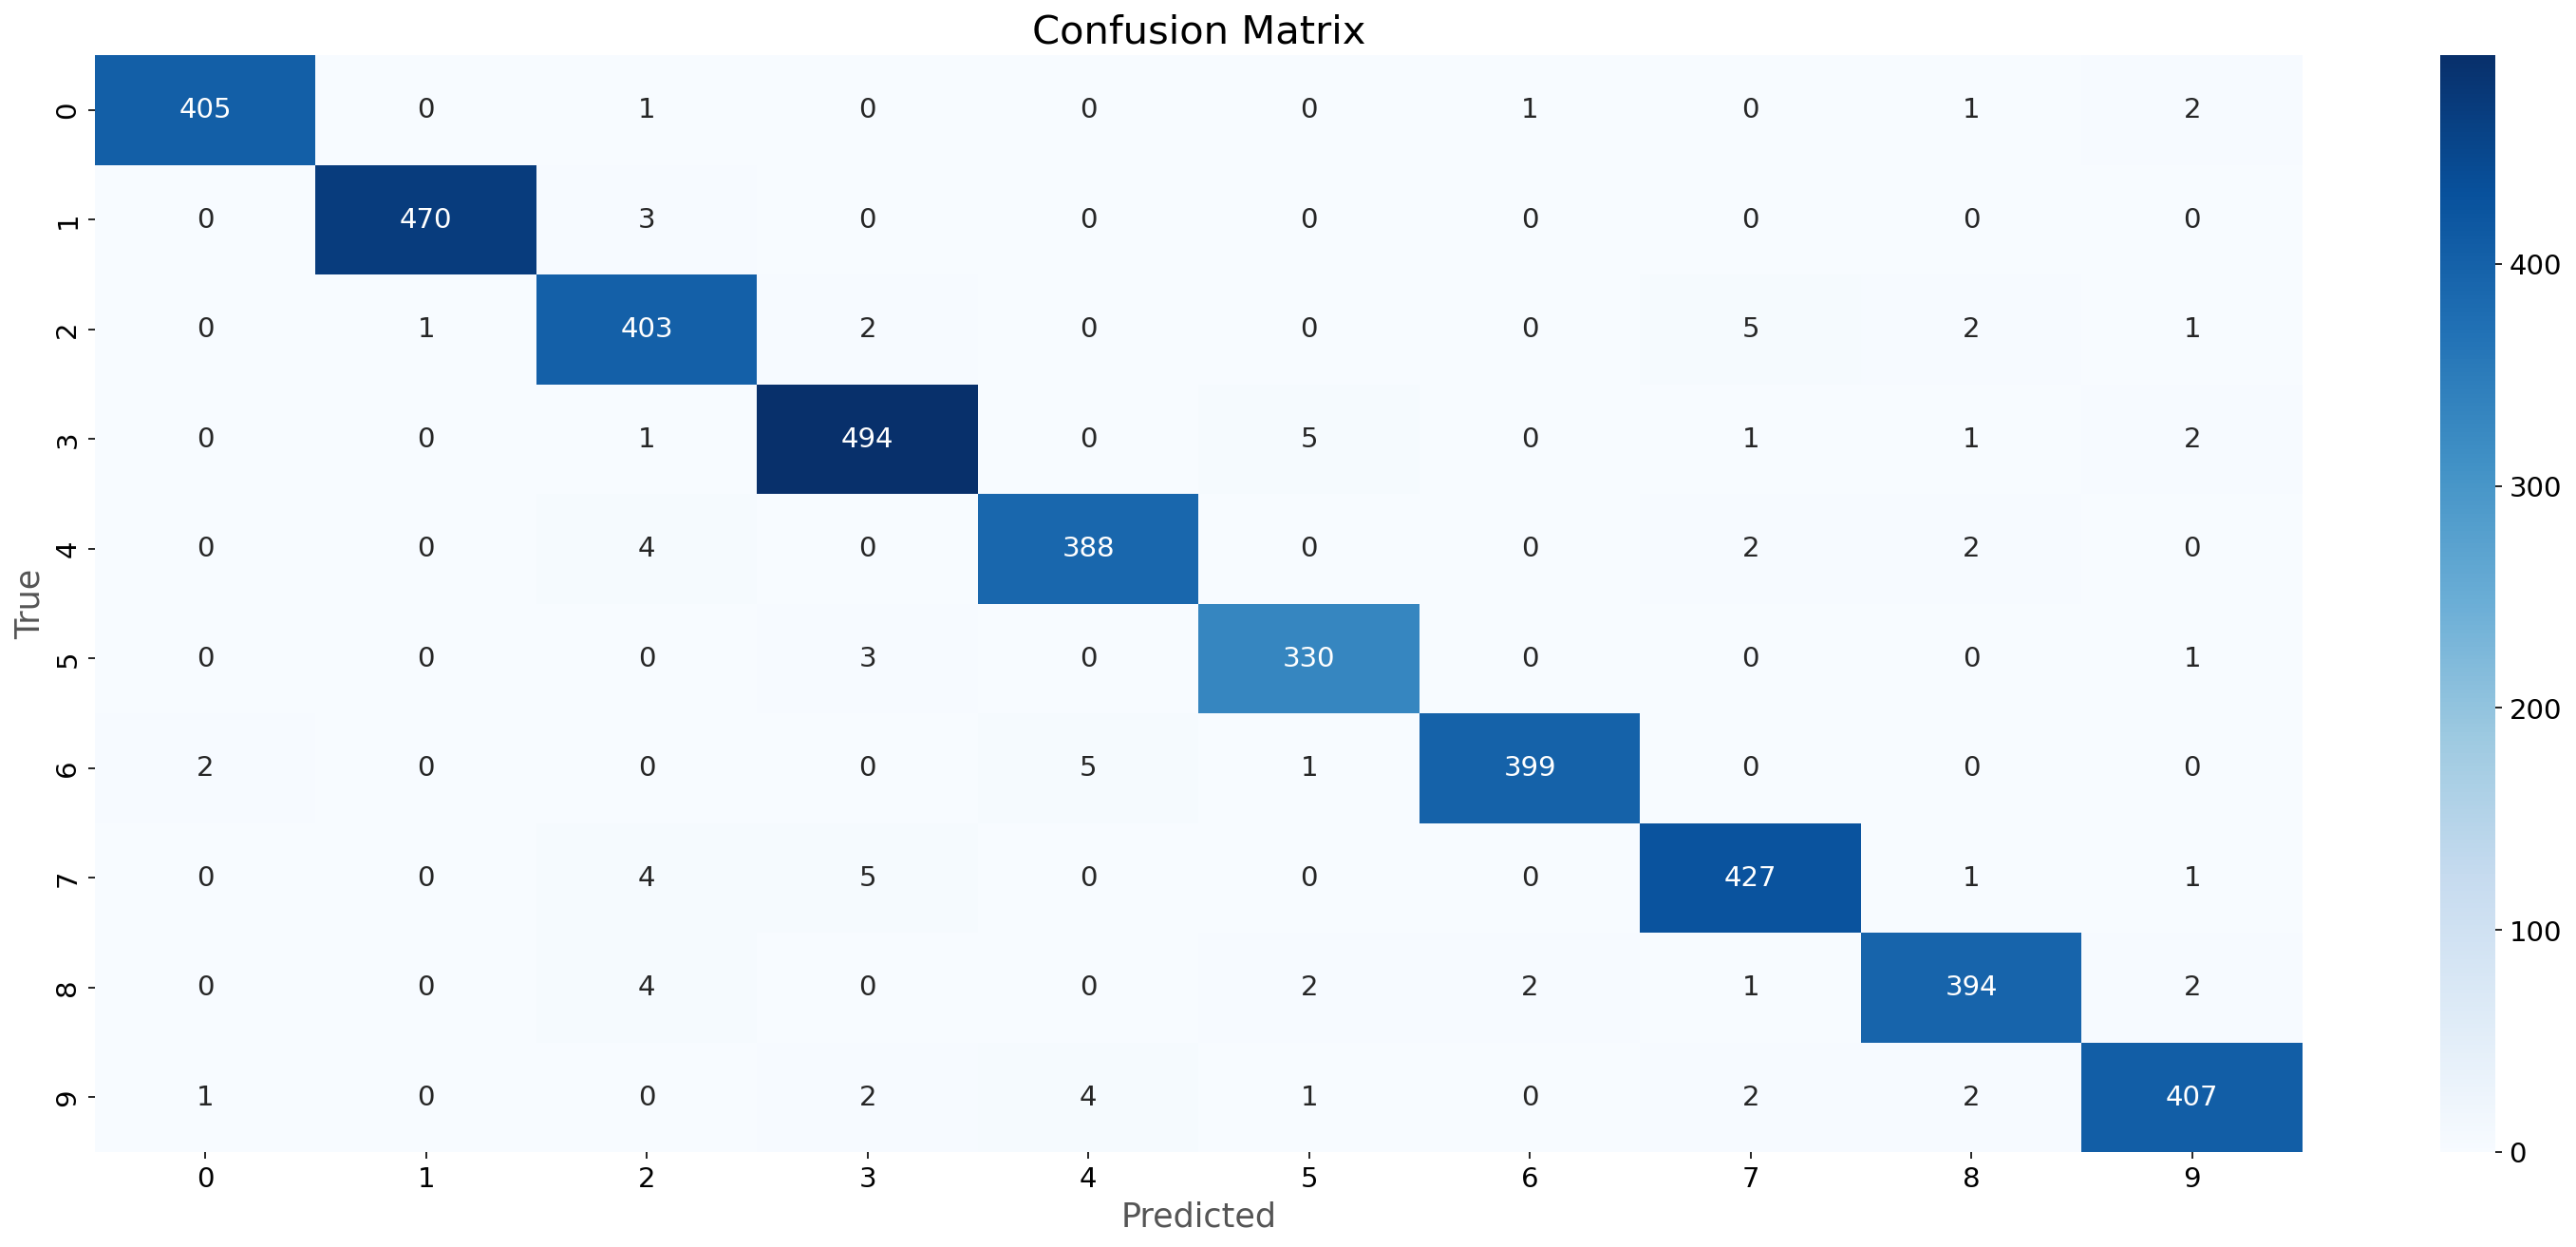

In [14]:
cm = confusion_matrix(y_val_pred, y_val_true)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


#### 2.2 Accuracy

In [45]:
print("Accuracy: ", accuracy_score(y_val_true, y_val_pred))


Accuracy:  0.9716666666666667


###### It isn't that much bad for our first model. Now we should look at the examples of the model is misclassified

### 3. The Primary Result Visualization


In [21]:
cm_index = cm
np.fill_diagonal(cm_index, 0)
cm_index = np.where(cm_index == cm_index.max())
if len(cm_index) > 1:
    cm_index = [cm_index[0][0], cm_index[1][0]]
cm_index


[2, 7]

##### The class with the most confusions is between class 2 and 7. let's take a look at incorrectly classified examples.

In [78]:
four_incorrect_examples = X_val[
    (y_val_true == cm_index[0]) & (y_val_pred == cm_index[1])
]
four_incorrect_examples = four_incorrect_examples.reshape(-1, 28, 28)
four_incorrect_examples.shape


(4, 28, 28)

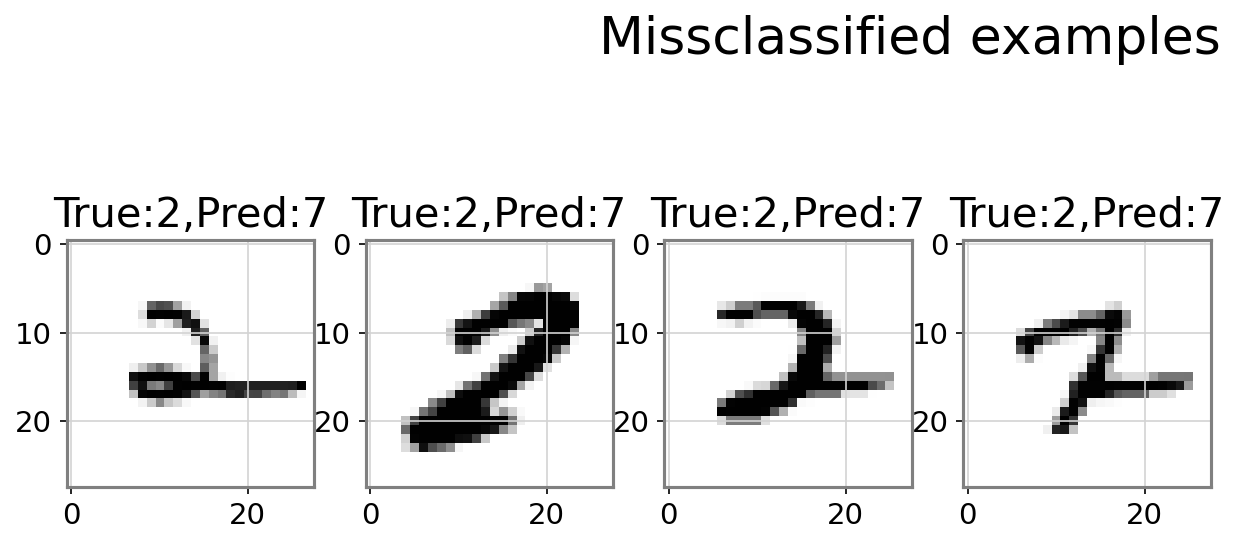

In [80]:
filters_layer_1 = model.layers[1].get_weights()[0]
filters_layer_1 = np.squeeze(filters_layer_1).reshape(32, 3, 3)

fig = plt.figure(figsize=(15, 15))
fig.suptitle("Missclassified examples")
columns = 6
rows = 6
for i in range(columns * rows + 1):
    if i == four_incorrect_examples.shape[0]:
        break
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(four_incorrect_examples[i], cmap="Greys")
    plt.title("True:{},Pred:{}".format(cm_index[0], cm_index[1]))

plt.show()


##### Looking at the missclassifications, its understandable why the model was unable classify these examples correctly. With the use of data augmentation and hyper-parameter tuning, we should be able to further improve performance.